**Results for SGLD case 1 (Kaczmarz, linear)**

about 30 minutes

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
print(jax.devices())
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import numpy as np 
from tqdm import tqdm
from omegaconf import OmegaConf
import matplotlib.pyplot as plt 

from examples.utils.sde import SDEIntegrator
from utils_Kaczmarz import randomized_kaczmarz, def_lstsq_1
from utils_Kaczmarz import build_OnsagerNetHD2
from utils_Kaczmarz import entropy_production_Kaczmarz

[CudaDevice(id=0)]


Distribution comparison

Least Squares Solution: [7.82606284 7.95040229 6.27184057 3.87593735 3.82678438 3.55390638
 2.50887362 5.14281966 2.88223371 4.04380187 5.91991938 6.45877829] 0.07307911190864053


Generating data:   0%|          | 0/100 [00:00<?, ?it/s]

Generating data: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


50
(100, 1000, 12)
Least Squares Solution: [7.82606284 7.95040229 6.27184057 3.87593735 3.82678438 3.55390638
 2.50887362 5.14281966 2.88223371 4.04380187 5.91991938 6.45877829] 0.07307911190864053


Generating data: 100%|██████████| 100/100 [00:04<00:00, 21.98it/s]


64
(100, 1000, 12)


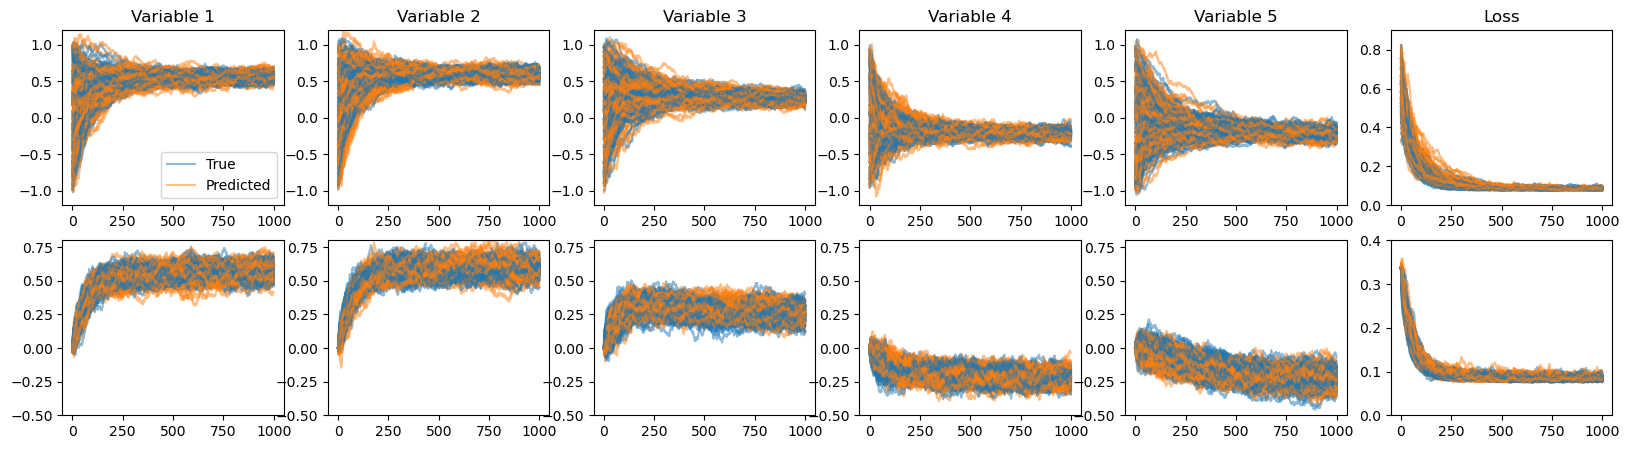

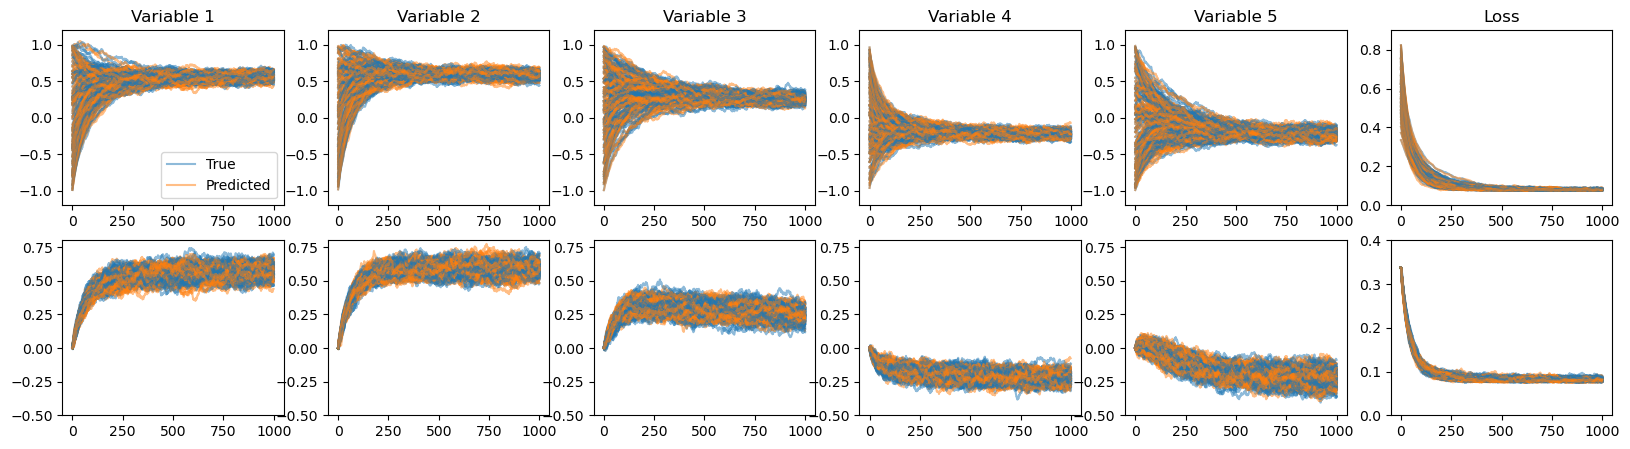

In [ ]:
def Distribution_comparison(batch_size, seed):
    # generate data
    total_seed = 100
    np.random.seed(0) 
    # construct target problem Ax = b
    A, b = def_lstsq_1()

    # run Kaczmarz
    Data_list0=[]
    import time 
    rng = np.random.default_rng(int(time.time_ns()) )
    x_initial = np.random.uniform(0,10, size=(total_seed, A.shape[1]))
    for s in tqdm(range(total_seed), desc="Generating data"):
        x0 = x_initial[s]
        x_est, residuals, X = randomized_kaczmarz(A, b, x0=x0, block_size=batch_size, max_iter=1000, lr=0.01)
        Data_list0.append(X)


    Data_list1=[]
    for s in tqdm(range(total_seed), desc="Generating data"):
        x0 = np.ones(A.shape[1])*5
        x_est, residuals, X = randomized_kaczmarz(A, b, x0=x0, block_size=batch_size, max_iter=1000, lr=0.01)
        Data_list1.append(X)
    Data_test0=np.array(Data_list0)
    Data_test1=np.array(Data_list1)

    # load model
    path =  "outputs/main_50scale{}_HD2".format(batch_size)
    config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
    model_template = build_OnsagerNetHD2(config, seed=seed) 
    net = eqx.tree_deserialise_leaves(os.path.join(path,'seed{}_models/model.eqx'.format(seed)), model_template)  
    print(net.potential.scale)

    # simulate learned SDE
    init_conditions = jnp.array(x_initial)/5-1
    integrator = SDEIntegrator(model=net, state_dim=12)
    key = jr.PRNGKey(0) 
    bm_keys = jr.split(key, 100) 
    sol = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=10,
        dt=0.01,
        args=[1],
    )
    predicted_trajectories0 = sol.ys



    init_conditions = jnp.zeros((100,12))
    integrator = SDEIntegrator(model=net, state_dim=12)
    key = jr.PRNGKey(0) 
    bm_keys = jr.split(key, 100) 
    sol = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=10,
        dt=0.01,
        args=[1],
    )
    predicted_trajectories1 = sol.ys


    # plot
    print(predicted_trajectories0.shape)
    fig, ax = plt.subplots(2,6, figsize=(20, 5))

    def loss_traj(traj):
        traj = jnp.array(traj)*5+5
        return jnp.linalg.norm(A.dot(traj.T) - b[:, None], axis=0) / jnp.linalg.norm(b)

    for j in [0,1,2,3,4]:
        for i in range(100):
            ax[0, j].plot(Data_test0[i,:,j]/5-1, color='C0', alpha=0.5)
            ax[0, j].plot(predicted_trajectories0[i,:,j], color='C1', alpha=0.5)


    for j in [0,1,2,3,4]:
        for i in range(100):
            ax[1, j].plot(Data_test1[i,:,j]/5-1, color='C0', alpha=0.5)
            ax[1, j].plot(predicted_trajectories1[i,:,j], color='C1', alpha=0.5)


    for i in range(100):
        ax[0, 5].plot(loss_traj(Data_test0[i]/5-1), color='C0', alpha=0.5)
        ax[0, 5].plot(loss_traj(predicted_trajectories0[i]), color='C1', alpha=0.5)
        ax[1, 5].plot(loss_traj(Data_test1[i]/5-1), color='C0', alpha=0.5)
        ax[1, 5].plot(loss_traj(predicted_trajectories1[i]), color='C1', alpha=0.5)
    ax[0,5].set_ylim(0, 0.9)
    ax[1,5].set_ylim(0, 0.9)

    ax[0, 0].plot(Data_test0[0,:,0]/5-1, color='C0', alpha=0.5, label='True')
    ax[0, 0].plot(predicted_trajectories0[0,:,0], color='C1', alpha=0.5, label='Predicted')
    ax[0,0].legend(loc='lower right')

    for j in [0,1,2,3,4]:
        ax[0, j].set_title(f'Variable {j+1}')
        ax[0, j].set_ylim(-1.2, 1.2)
        ax[1, j].set_ylim(-0.5, 0.8)
        ax[0, j].set_rasterized(True)
        ax[1, j].set_rasterized(True)
    ax[0, 5].set_title('Loss')
    ax[0, 5].set_ylim(0,0.9)
    ax[1, 5].set_ylim(0,0.4)
    ax[0, 5].set_rasterized(True)
    ax[1, 5].set_rasterized(True)

    plt.savefig('results/relat4_batchsize_{}_seed_{}.svg'.format(batch_size, seed), bbox_inches='tight', pad_inches=0.1)

Distribution_comparison(batch_size=1, seed=10)
Distribution_comparison(batch_size=64, seed=10)

EPR computation

In [ ]:
ep_all_batch = []
for  batch_size in [1, 2, 4, 8, 16, 32, 64]:
    ep_current_batch=[]
    for seed in [10, 20, 30, 40]:
        path =  f"outputs/main_50scale{batch_size}_HD2" 
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2(config, seed=seed)
        net = eqx.tree_deserialise_leaves(os.path.join(path,f'seed{seed}_models/model.eqx'), model_template)

        ep, pre_traj = entropy_production_Kaczmarz(net, temperature=1.0, end_time=10, dt=0.005)
        ep_current_batch.append(ep)
    ep_all_batch.append(ep_current_batch)

In [ ]:
from utils_Kaczmarz import determitic_kaczmarz
total_seed = 1000
np.random.seed(0) 
# construct target problem Ax = b
A, b = def_lstsq_1()
# run Kaczmarz
Data_all_batch=[]
for batch_size in [1, 2, 4, 8, 16, 32, 64]:
    Data_list0=[]
    import time
    seed = int(time.time_ns())
    rng = np.random.default_rng(seed)
    x_initial = np.random.uniform(0,10, size=(total_seed, A.shape[1]))
    for s in tqdm(range(total_seed), desc="Generating data"):
        x0 = x_initial[s]
        x_est, residuals, X = randomized_kaczmarz(A, b, x0=x0, block_size=batch_size, max_iter=2000, lr=0.01)
        Data_list0.append(X)
    Data_all_batch.append(Data_list0)
Data_deter=[]
import time
seed = int(time.time_ns())
rng = np.random.default_rng(seed)
x_initial = np.random.uniform(0,10, size=(total_seed, A.shape[1]))
for s in tqdm(range(total_seed), desc="Generating data"):
    x0 = x_initial[s]
    x_est, residuals, X = determitic_kaczmarz(A, b, x0=x0, block_size=batch_size, max_iter=2000, lr=0.01)
    Data_deter.append(X)

import numpy as np
from sklearn.metrics import pairwise_kernels
from sklearn.model_selection import train_test_split
 
X_sampled = (np.array(Data_deter)[:,-10:]).reshape(-1,12)
print(X_sampled.shape)

mmd1_values=[]
for i in range(len(Data_all_batch)):
    print(i)
    Y_sampled = (np.array(Data_all_batch[i])[:,-10:]).reshape(-1,12)
    # Computation of Gaussion kernal matrix for MMD
    gamma = 1.0
    XX = pairwise_kernels(X_sampled, X_sampled, metric='rbf', gamma=gamma)
    YY = pairwise_kernels(Y_sampled, Y_sampled, metric='rbf', gamma=gamma)
    XY = pairwise_kernels(X_sampled, Y_sampled, metric='rbf', gamma=gamma)

    # 计算MMD^2
    mmd_squared = XX.mean() + YY.mean() - 2 * XY.mean()
    print("MMD^2:", mmd_squared)
    mmd1_values.append(mmd_squared)

mmd2_values=[]
for i in range(len(Data_all_batch)-1):
    print(i)
    Y_sampled = (np.array(Data_all_batch[i])[:,-10:]).reshape(-1,12)
    X_sampled = (np.array(Data_all_batch[i+1])[:,-10:]).reshape(-1,12)
    # Computation of Gaussion kernal matrix for MMD
    gamma = 1.0
    XX = pairwise_kernels(X_sampled, X_sampled, metric='rbf', gamma=gamma)
    YY = pairwise_kernels(Y_sampled, Y_sampled, metric='rbf', gamma=gamma)
    XY = pairwise_kernels(X_sampled, Y_sampled, metric='rbf', gamma=gamma)

    # Computation of MMD^2
    mmd_squared = XX.mean() + YY.mean() - 2 * XY.mean()
    print("MMD^2:", mmd_squared)
    mmd2_values.append(mmd_squared)

Least Squares Solution: [7.82606284 7.95040229 6.27184057 3.87593735 3.82678438 3.55390638
 2.50887362 5.14281966 2.88223371 4.04380187 5.91991938 6.45877829] 0.07307911190864053


Generating data: 100%|██████████| 1000/1000 [01:30<00:00, 11.10it/s]


(10000, 12)
0
MMD^2: 0.00864550976258871
1
MMD^2: 0.0033435148317524366
2
MMD^2: 0.0022544857716941813
3
MMD^2: 0.0013439443189946498
4
MMD^2: 0.0010845030375633558
5
MMD^2: 0.0010785611989689858
6
MMD^2: 0.0012867873138910912
0
MMD^2: 0.0024390179557814973
1
MMD^2: 0.0011999109996377877
2
MMD^2: 0.0015347565956256304
3
MMD^2: 0.0008720946544075181
4
MMD^2: 0.0013298306294293738
5
MMD^2: 0.000902958220289185


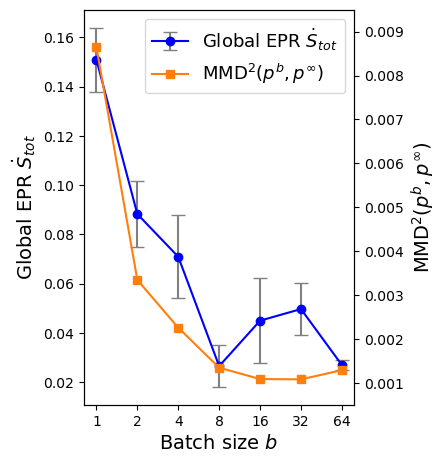

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

ep= np.array(ep_all_batch)
mean_ep = ep.mean(axis=1)
std_ep = ep.std(axis=1)

# ---------- 
# Layout parameters (inches): 
# Fixing these ensures that the physical dimensions of the "true drawing area" do not change with the length of the data
# ----------
fig_size = (4.5,5)              # overall figure size in inches
left_margin_inch = 0.90
right_margin_inch = 0.90
bottom_margin_inch = 0.70
top_margin_inch = 0.35

label_fontsize = 14
tick_fontsize = 10

# compute relative fraction for add_axes
fig_w, fig_h = fig_size
left_frac = left_margin_inch / fig_w
right_frac = right_margin_inch / fig_w
bottom_frac = bottom_margin_inch / fig_h
top_frac = top_margin_inch / fig_h

width_frac = 1.0 - left_frac - right_frac
height_frac = 1.0 - bottom_frac - top_frac
if width_frac <= 0 or height_frac <= 0:
    raise ValueError("Margins are too large. Please reduce the margins or increase fig_Size.")

# ---------- PLOT ----------
fig = plt.figure(figsize=fig_size, dpi=100)
ax1 = fig.add_axes([left_frac, bottom_frac, width_frac, height_frac])  # left, bottom, width, height (fractions)

# ---------- Left vertical axis: Entropy Production Rate ----------
x_ep = np.arange(1, len(mean_ep) + 1)
ax1.errorbar(
    x_ep, mean_ep, yerr=std_ep,
    fmt='o-', capsize=5, color='b', ecolor='gray',
    label=r'Global EPR $\dot{S}_{tot}$'
)
ax1.set_xlabel(r"Batch size $b$", fontsize=label_fontsize)
ax1.set_ylabel(r"Global EPR $\dot{S}_{tot}$", fontsize=label_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

ax1.set_xticks(np.arange(1, 8))
ax1.set_xticklabels([1, 2, 4, 8, 16, 32, 64])

# ---------- Right vertical axis: MMD^2 ----------
ax2 = ax1.twinx()
x_mmd = np.arange(1, len(mmd1_values) + 1)
ax2.plot(
    x_mmd, mmd1_values,
    's-', color='C1', label='MMD$^2(p^b,p^{\infty})$'
)
ax2.set_ylabel('MMD$^2(p^b,p^{\infty})$', fontsize=label_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)

ax2.set_ylim(0.0005, 0.0095) 

ax1.grid(False)
ax2.grid(False)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=13, loc='upper right')
 
plt.savefig("results/error1.svg", dpi=300) 

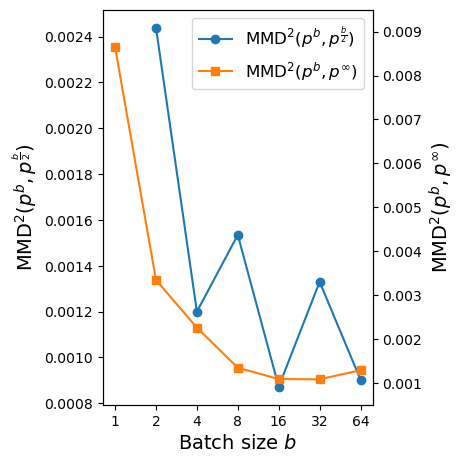

In [ ]:
# ---------- 
# Layout parameters (inches): 
# Fixing these ensures that the physical dimensions of the "true drawing area" do not change with the length of the data
# ----------
fig_size = (4.5,5)              # overall figure size in inches
left_margin_inch = 0.90
right_margin_inch = 0.90
bottom_margin_inch = 0.70
top_margin_inch = 0.35

label_fontsize = 14
tick_fontsize = 10

# compute relative fraction for add_axes
fig_w, fig_h = fig_size
left_frac = left_margin_inch / fig_w
right_frac = right_margin_inch / fig_w
bottom_frac = bottom_margin_inch / fig_h
top_frac = top_margin_inch / fig_h

width_frac = 1.0 - left_frac - right_frac
height_frac = 1.0 - bottom_frac - top_frac
if width_frac <= 0 or height_frac <= 0:
    raise ValueError("Margins are too large. Please reduce the margins or increase fig_Size.")

# ---------- PLOT ----------
fig = plt.figure(figsize=fig_size, dpi=100)
ax1 = fig.add_axes([left_frac, bottom_frac, width_frac, height_frac])  # left, bottom, width, height (fractions)

# ---------- Left vertical axis: MMD^2(b, b/2) ----------
x_mmd_d = np.arange(1, len(mmd2_values) + 1)+1
ax1.plot(
    x_mmd_d, mmd2_values,
    'o-', color='C0', label=r'MMD$^2(p^b,p^{\frac{b}{2}})$'
)
ax1.set_xlabel(r"Batch size $b$", fontsize=label_fontsize)
ax1.set_ylabel(r'MMD$^2(p^b,p^{\frac{b}{2}})$', fontsize=label_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

ax1.set_xticks(np.arange(1, 8))
ax1.set_xticklabels([1, 2, 4, 8, 16, 32, 64])

# ---------- Right vertical axis: MMD^2(b, \infty) ----------
ax2 = ax1.twinx()
x_mmd = np.arange(1, len(mmd1_values) + 1) 
ax2.plot(
    x_mmd, mmd1_values,
    's-', color='C1', label='MMD$^2(p^b,p^{\infty})$'
)
ax2.set_ylabel('MMD$^2(p^b,p^{\infty})$', fontsize=label_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)

ax2.set_ylim(0.0005, 0.0095) 

ax1.grid(False)
ax2.grid(False)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=12, loc='upper right')
plt.savefig("results/error_d_1.svg", dpi=300) 